(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Clustering the data from the Mayor's 24-hour hotline in Boston

## Introduction 

In this assignment, we will do a clustering analysis on the 311 calls that we used in the previous homework. We will focus on choosing a value for k, clustering based on multiple features and detecting outliers.

---------------------------

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 12)

The function below takes as input an `Axes` object and draws the Boston area. We have already downloaded the required data from [BostonMaps Open Data](http://bostonopendata.boston.opendata.arcgis.com/) (i.e. the shapefiles for the different districts, the water bodies and the open spaces). You can also download these from here:
* [Hydrography](http://cs-people.bu.edu/cmav/cs591/solutions/Homework-3/Hydrography_poly.zip)
* [Open spaces](http://cs-people.bu.edu/cmav/cs591/solutions/Homework-3/Open_Space.zip)
* [Districts](http://cs-people.bu.edu/cmav/cs591/solutions/Homework-3/Zoning_Districts.zip)

In [2]:
# Define a function to plot the map of Boston
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape

def draw_boston(ax):
    neighborhoods = MultiPolygon([shape(pol['geometry']) 
                                  for pol in fiona.open('Zoning_Districts/Zoning_Districts.shp')
                                  ])
    hydro = MultiPolygon([shape(pol['geometry'])
                          for pol in fiona.open('Hydrography_poly/Hydrography_poly.shp')
                          ])
    open_spaces = MultiPolygon([shape(pol['geometry']) 
                                for pol in fiona.open('Open_Space/Open_Space.shp')
                                ])
    minx, miny, maxx, maxy = hydro.bounds
    maxx = -70.97; maxy = 42.4
    w, h = maxx - minx, maxy - miny
    ax.set_xlim(minx, maxx )
    ax.set_ylim(miny, maxy)
    ax.set_aspect(1)

    patches = []
    for idx, p in enumerate(neighborhoods):
        patches.append(PolygonPatch(p, fc='lightgray', ec='#2c2c2c', alpha=1, zorder=1, lw=1.5))
    for idx, p in enumerate(hydro):
        patches.append(PolygonPatch(p, fc='lightblue', ec='#555555', alpha=1, zorder=2))
    for idx, p in enumerate(open_spaces):
        patches.append(PolygonPatch(p, fc='white', ec='#555555', alpha=1., zorder=3))
    ax.add_collection(PatchCollection(patches, match_original=True))
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(bottom=True, left=True)
    return ax

ImportError: No module named fiona

NameError: name 'draw_boston' is not defined

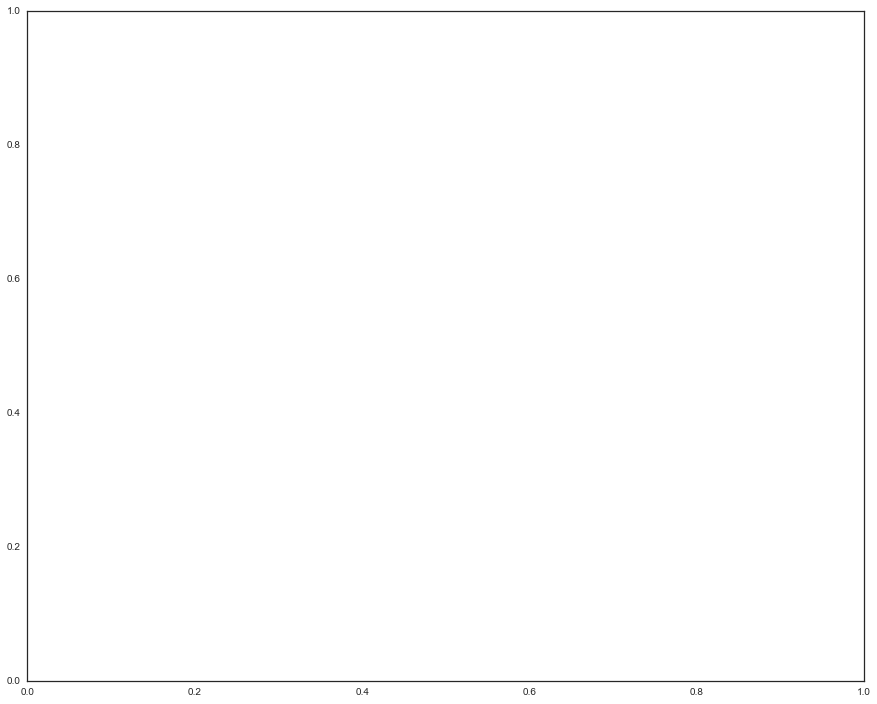

In [3]:
with sns.axes_style('white'):
    ax = plt.subplot(111)
    ax = draw_boston(ax)
    plt.show()

In [4]:
boston = pd.read_csv('cases_2015.csv')

## Step 1. Simple clustering

The first thing that we will try is to cluster the geolocation data of the calls. The geolocation of a record consists of a pair `(latitude, longitude)`, which represents the position of the record on the map. Since the dataset that we have spans only a small geographic location, i.e. Boston, we will use the Euclidean distance when measuring how close two points are. Techinically, we should pick a [projection](https://github.com/mbostock/d3/wiki/Geo-Projections) in order to transform the data into 2d, and measure  the Euclidean distance in the projected space.

Since we are dealing with numeric data, we might considering centering and normalizing them. In order to do that, check the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) from `scikit-learn`.

Filter the dataset to get the latitude and longitude, transform it as required and run the k-means clustering algorithm. Argue about the number of clusters you used. **(pts 50)**

We first scale the latitude and longitude of the records such that their mean is 0 and their standard deviation is 1. This is a common preprocessing step when clustering.

In [5]:
from sklearn.preprocessing import StandardScaler

X = boston.LONGITUDE.values
Y = boston.LATITUDE.values
X_scaler = StandardScaler(with_std=True)
scaled_X = X_scaler.fit_transform(X)
Y_scaler = StandardScaler(with_std=True)
scaled_Y = Y_scaler.fit_transform(Y)
boston['SCALED_LONG'] = scaled_X
boston['SCALED_LAT'] = scaled_Y

In [6]:
from sklearn.cluster import KMeans

def evaluate_clustering(X, max_k):
    """Plots the inertia of a clustering for different choices of cluster numbers.
    
    Parameters
    ----------
    X : matrix
        The data to be clustered.
    max_k : int
        The maximum number of clusters to try.
        
    Returns
    -------
    inertia : list
        The inertia for each choice of k.
    """
    inertia = []
    inertia.append(0)
    for k in range(1, max_k + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=5)
        kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
    return inertia

In [7]:
from numpy import hstack
from numpy import atleast_2d, where

data = hstack((atleast_2d(scaled_X).T, atleast_2d(scaled_Y).T))
inertia_k = evaluate_clustering(data, 15)

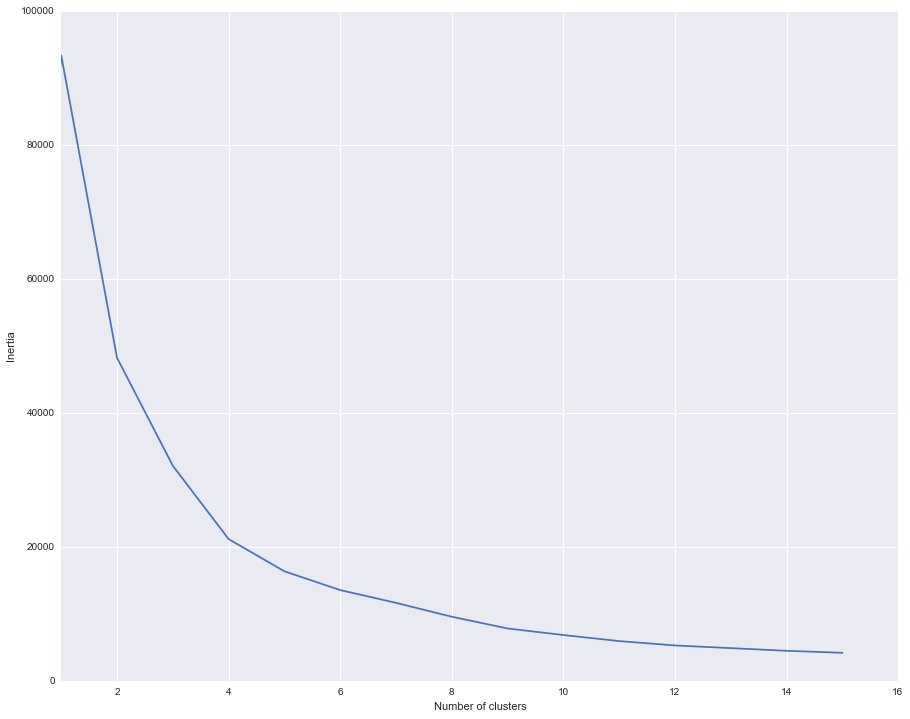

In [8]:
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))
plt.show()

Based on the plot above, we will choose 5 as the number of clusters.

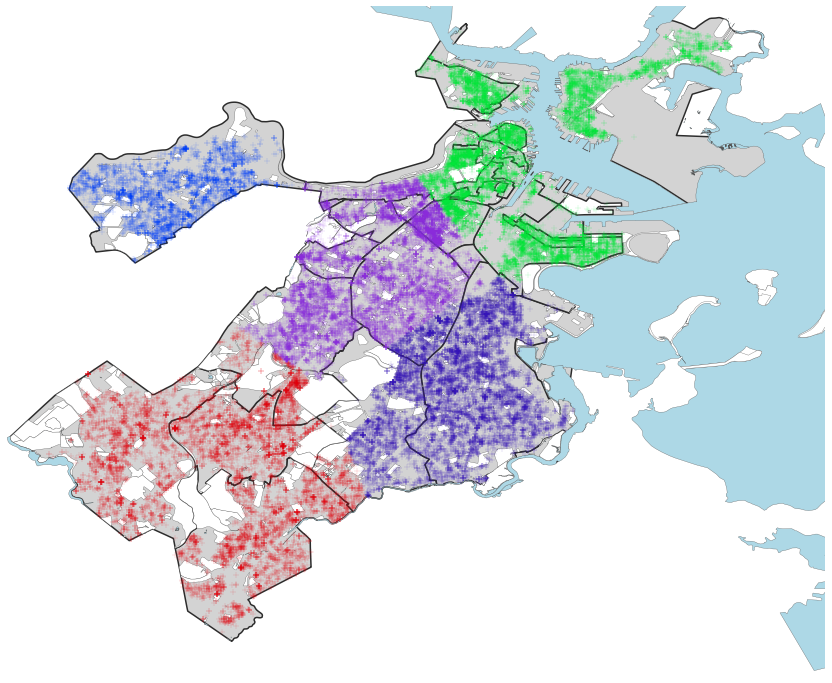

In [46]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(data)

with sns.axes_style("white"):
    ax = plt.subplot(111)
    ax = draw_boston(ax)
    
    # Define a color palette
    cmap = sns.color_palette("bright", n_colors=4)
    cmap.extend(sns.hls_palette(n_colors=6, h=0.7, l=0.4, s=0.8))

    # Iterate over the different clustering labels, find the points
    # that belong to that cluster and plot them with the same color
    for i, label in enumerate(set(labels)):
        point_indices = where(labels == label)[0]
        point_indices = point_indices.tolist()
        ax.scatter(X[point_indices], Y[point_indices], s=35, 
                    alpha=0.4, c=cmap[i], marker='+')

As expected, the clustering does not resemble the districts of Boston (except perhaps the fact that the Allston/Brighton neighborhood is identified). The reason is that points in a densily populated space will be partitioned as a [Voronoi diagram](http://en.wikipedia.org/wiki/Voronoi_diagram).

-----

## Step 2. Using multiple features

The next step in our analysis is to use more features than just the geolocation of a record (whose clustering only gives us information about the districts, which should not be a huge revelation!) Filter the dataset to get more features, transform them as required and compute another clustering. You can still use the geolocation for your final plot. You should argue about the quality of your clustering and use domain knowledge (i.e. the fact that you are locals) to explore the clusters you produced and present them to the reader. **(pts 30)**

We will create a new feature to measure the response time to a report. We will call it `RESPONSE_TIME`. We also add a scaled version of it, to enhance the clustering quality. If a report remains `Open`, we assign a response time of -1.

In [9]:
import sys
import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def response_time(row):
    if row.CASE_STATUS == "Closed":
        opened = datetime.datetime.strptime(row.OPEN_DT, "%Y-%m-%d %H:%M:%S")
        closed = datetime.datetime.strptime(row.CLOSED_DT, "%Y-%m-%d %H:%M:%S")
        return (closed - opened).days
    else:
        return -1

boston['RESPONSE_TIME'] = boston.apply(response_time, axis = 1)
boston['SCALED_RESPONSE'] = -1
boston['SCALED_RESPONSE'][boston.CASE_STATUS=="Closed"] = \
    MinMaxScaler(copy=True).fit_transform(boston.RESPONSE_TIME[boston.CASE_STATUS=="Closed"] * 1.)

C:\Users\Roberto\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The code above may produce the following warning.


    -c:16: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame

    See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
    
This is because of the last line of code, where we are trying to update the values of a slice of the DataFrame. However, it should still work.

Next, we will create 3 boolean features from the categorical feature `Source`. We want to explore how many reports were placed by the citizens and what device was used, if any.

In [10]:
print boston.Source.value_counts()
boston['SOURCE_CALL'] = boston.Source.apply(lambda row: 1 if row == "Constituent Call" else 0)
boston['SOURCE_APP'] = boston.Source.apply(lambda row: 1 if row == "Citizens Connect App" else 0)
boston['SOURCE_EMPLOYEE'] = boston.Source.apply(lambda row: 1 if "Worker" in row 
                                                                or "Employee" in row
                                                            else 0)

Constituent Call        29037
Citizens Connect App     9032
Self Service             5978
City Worker App          1628
Employee Generated        982
Maximo Integration         41
dtype: int64


We now generate a subset of our original dataset, which we will cluster.

In [11]:
dataset = boston[['SOURCE_CALL', 'SOURCE_APP', 
                  'SOURCE_EMPLOYEE', 'SCALED_RESPONSE',
                  'SCALED_LONG', 'SCALED_LAT',
                  'LONGITUDE', 'LATITUDE']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46698 entries, 0 to 46697
Data columns (total 8 columns):
SOURCE_CALL        46698 non-null int64
SOURCE_APP         46698 non-null int64
SOURCE_EMPLOYEE    46698 non-null int64
SCALED_RESPONSE    46698 non-null float64
SCALED_LONG        46698 non-null float64
SCALED_LAT         46698 non-null float64
LONGITUDE          46698 non-null float64
LATITUDE           46698 non-null float64
dtypes: float64(5), int64(3)
memory usage: 3.2 MB


-----

In [12]:
inertia_k = evaluate_clustering(dataset[['SOURCE_CALL',
                                         'SOURCE_APP',
                                         'SOURCE_EMPLOYEE',
                                         'SCALED_RESPONSE']],
                                8)

In [2]:
ax = plt.subplot(111)
ax.plot(inertia_k)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
ax.set_xlim(1, len(inertia_k))
plt.show()

NameError: name 'plt' is not defined

We choose to cluster our data in 5 clusters.

In [14]:
from sklearn.cluster import k_means
n_clusters = 5
centroids, labels, inertia = k_means(dataset[['SOURCE_CALL',
                                              'SOURCE_APP',
                                              'SOURCE_EMPLOYEE',
                                              'SCALED_RESPONSE']],
                                     n_clusters=n_clusters,
                                     random_state =150)
centroids = pd.DataFrame(centroids,
                         columns=('SOURCE_CALL',
                                  'SOURCE_APP', 
                                  'SOURCE_EMPLOYEE',
                                  'SCALED_RESPONSE'))
print centroids

    SOURCE_CALL    SOURCE_APP  SOURCE_EMPLOYEE  SCALED_RESPONSE
0  1.000000e+00 -1.484923e-14    -7.022161e-15        -1.000000
1  2.720046e-14 -7.438494e-15     2.856941e-01         0.076116
2  1.000000e+00  6.064593e-14     1.686845e-14         0.082030
3  2.020606e-14  1.000000e+00    -5.155598e-15         0.077169
4 -4.773959e-15  5.720633e-01     1.624549e-01        -1.000000


Next, we want to show the different clusters and describe the data points that they contain. For each cluster, we will present two plots: One will show the distribution of the points on the map and the other will describe the distribution of the values of the points. The second plot is something that you might have not seen before. It's called [Violin plot](http://en.wikipedia.org/wiki/Violin_plot) and is similar to the boxplot. The only difference is that it also describes the distribution of the values within the box, which is captured by the width of the "violin". When a variable is boolean, it collapses into a vertical bar.

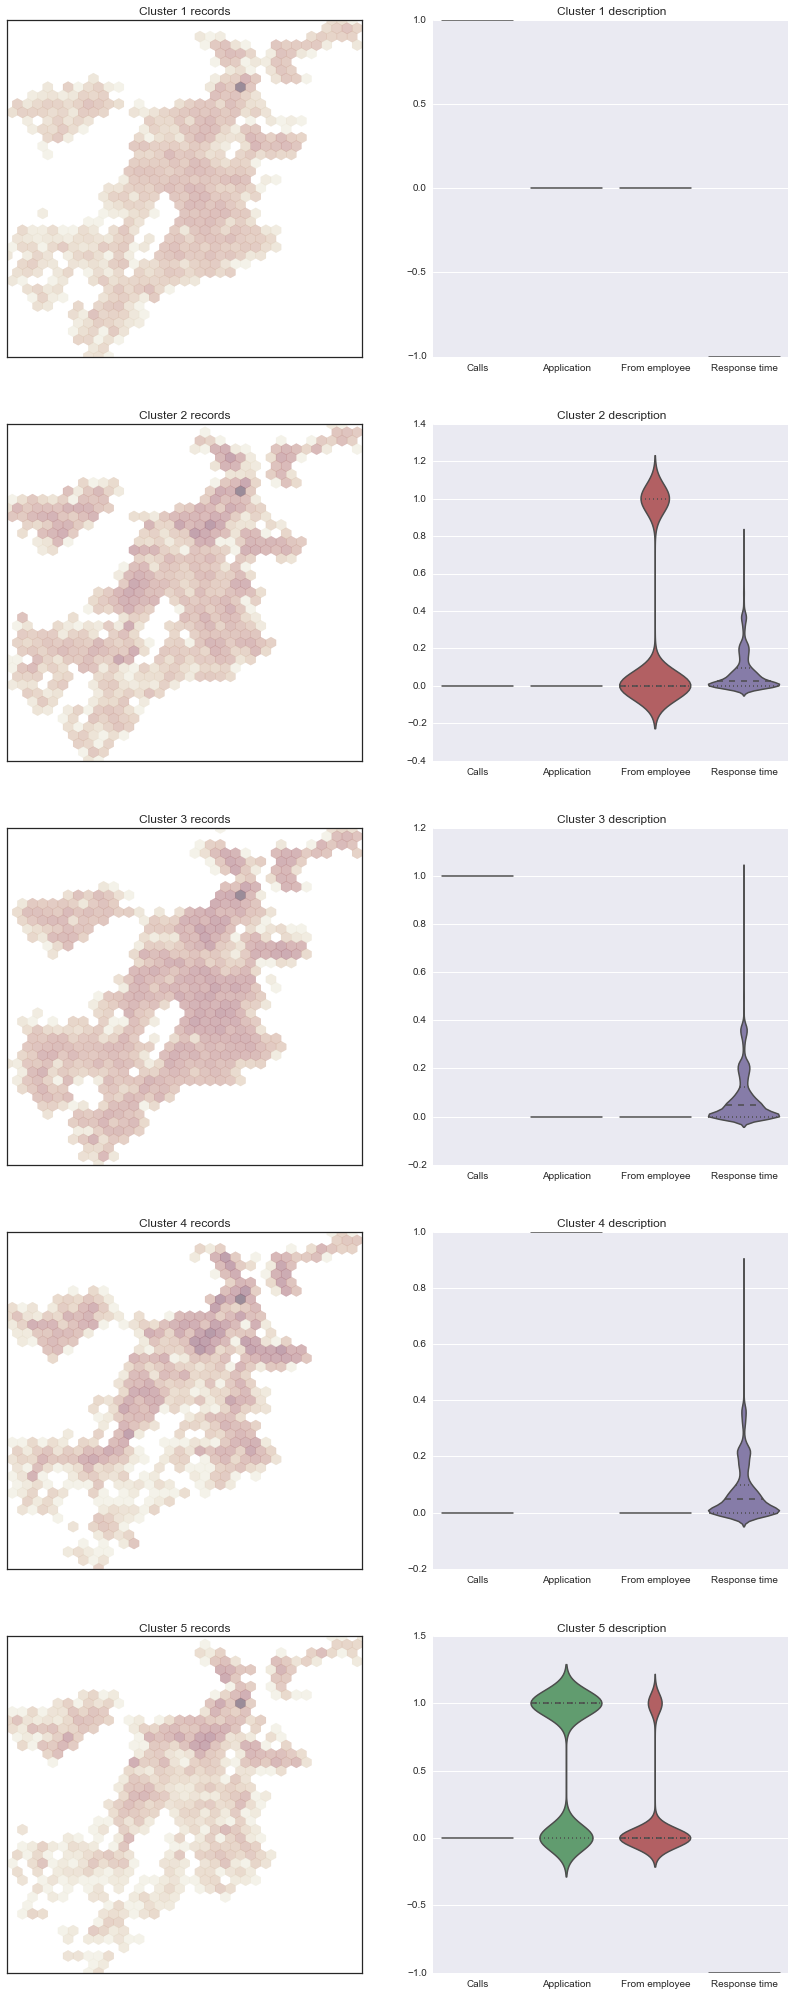

In [17]:
cmap = sns.cubehelix_palette(start=0.3, light=0.9, as_cmap=True)
titles=["Calls", "Application", "From employee", "Response time"]
plt.rcParams['figure.figsize'] = (14,7 * n_clusters)

for i, label in enumerate(set(labels)):
    point_indices = where(labels == label)[0]
    point_indices = point_indices.tolist()
    cluster = dataset.iloc[point_indices]
    with sns.axes_style("white"):
        ax = plt.subplot(n_clusters, 2, 2 * i + 1)
#        ax = draw_boston(ax)
        ax.hexbin(cluster.LONGITUDE,
                      cluster.LATITUDE,
                      bins='log',
                      gridsize=35,
                      cmap=cmap, alpha=0.5, mincnt=1)
        ax.set_title("Cluster %d records" % (i + 1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    with sns.axes_style('darkgrid'):
        ax = plt.subplot(n_clusters, 2, 2 * i + 2)
        sns.violinplot(cluster[['SOURCE_CALL', 'SOURCE_APP', 
                      'SOURCE_EMPLOYEE', 'SCALED_RESPONSE']],
                       ax=ax,
                       names=titles)
        ax.set_title("Cluster %d description" % (i + 1))
        
# restore the default figure size
plt.rcParams['figure.figsize'] = (15,12)

## Step 3. Detecting outliers

Now that we have a clustering of the records in the dataset, we can detect the outlying ones. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(pts 20)** 

We will define the outliers as the points in the cluster that are the furthest from the cluster centroid. The distance between two vectors $a$ and $b$ can be measured from the euclidean norm of their difference. $$\| a - b \|_2$$

In the code below, we want to find at least $20$ outliers. If all of the points are exactly the same as the centroid, as in the case of cluster $1$, we won't report anything.

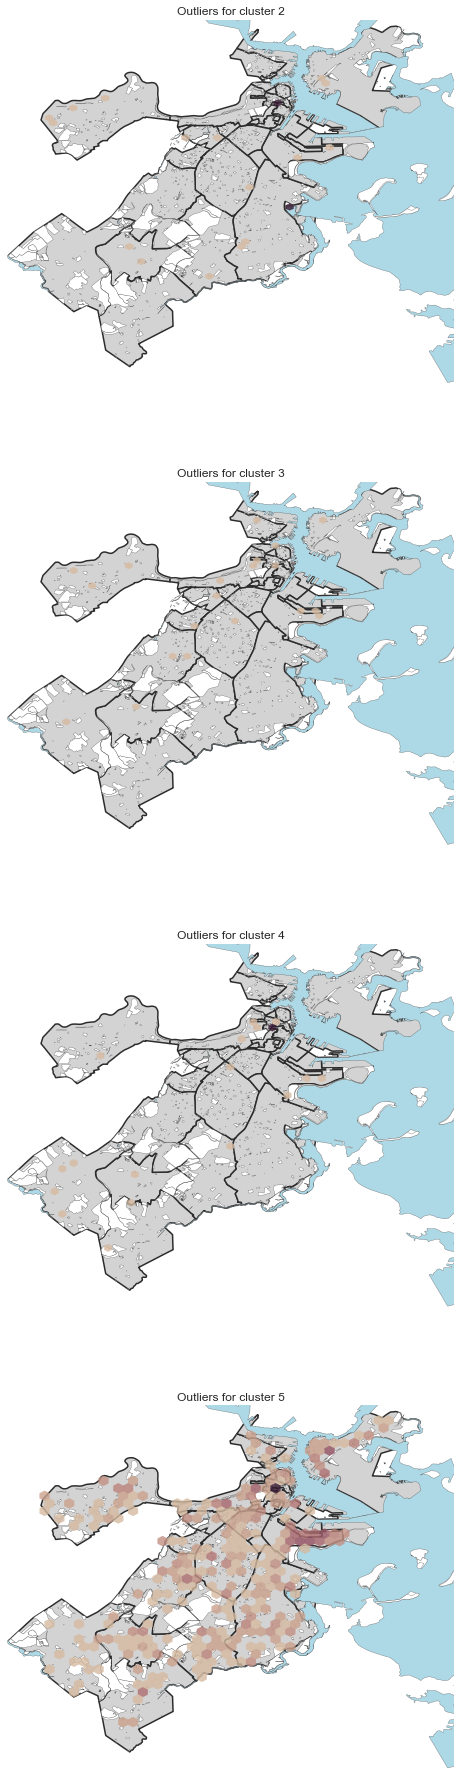

In [61]:
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
from numpy import argpartition
plt.rcParams['figure.figsize'] = (8, 8 * n_clusters)

clustered_points = dataset[['SOURCE_CALL',
                            'SOURCE_APP',
                            'SOURCE_EMPLOYEE',
                            'SCALED_RESPONSE']]
top = 20
cmap = sns.cubehelix_palette(start=0.3, light=0.75, as_cmap=True)

for i, label in enumerate(set(labels)):
    cluster_point_indices = where(labels == label)[0]
    cluster_point_indices = cluster_point_indices.tolist()
    cluster = clustered_points.iloc[cluster_point_indices]
    
    cluster_vectors = csr_matrix(cluster.values)
    centroid_vector = csr_matrix(centroids.values[i,:])
    
    distances =  cdist(cluster_vectors.todense(), 
                       centroid_vector.todense(), 
                       'euclidean')
    max_distance_index = np.argmax(distances)
    outlier_indices = where(distances == distances[max_distance_index])[0]
        
    if len(outlier_indices) < top :
        # if the outliers are less than 20, find the 20 first
        outlier_indices = argpartition(distances[:,0], -top)[-top:]
    outlier_indices = outlier_indices.tolist()
    if len(outlier_indices) == distances.shape[0] or len(outlier_indices)<10e-10:
        continue
    else:
        outliers = dataset.iloc[outlier_indices]
        with sns.axes_style("white"):
            ax = plt.subplot(n_clusters, 1, i + 1)
            ax = draw_boston(ax)
            ax.hexbin(outliers.LONGITUDE,
                      outliers.LATITUDE,
                      bins='log',
                      gridsize=35,
                      cmap=cmap,
                      mincnt=1,
                      alpha=0.8)
            ax.set_title("Outliers for cluster %d" % (i + 1))


plt.rcParams['figure.figsize'] = (15,12)  

It's worth mentioning that for the 5th cluster, there seems to be high concentration of outliers in the are of South Boston. Remember, this cluster describes records that were **not** made through a call (so either the application or by walking in the city hall) and that were not closed. If we take into consideration the violin plots for that cluster, these reports could be from employees of the city of Boston, using their application or through the [IBM Maximo](http://www.ema-inc.com/success-stories/asset-management/city-of-boston-ibm-maximo-implementation) system.

In [12]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()